In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
DATASET_PATH = 'Data/genres_original'

data_dir = pathlib.Path(DATASET_PATH)

In [3]:
music_genres = np.array(tf.io.gfile.listdir(str(data_dir)))
music_genres = music_genres[(music_genres != 'README.md') & (music_genres != '.DS_Store')]
print('music_genres:', music_genres)

music_genres: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


In [4]:
#Preprocess

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 999 files belonging to 10 classes.
Using 800 files for training.
Using 199 files for validation.

label names: ['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


In [5]:
#The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of (batch, samples, channels)
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [6]:
#This dataset only contains single channel audio, so use the tf.squeeze function to drop the extra axis:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [7]:
#Validation set
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [8]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)
    

(64, 16000)
(64,)


In [9]:
label_names[[1,1,3,0]]

array(['classical', 'classical', 'disco', 'blues'], dtype='<U9')

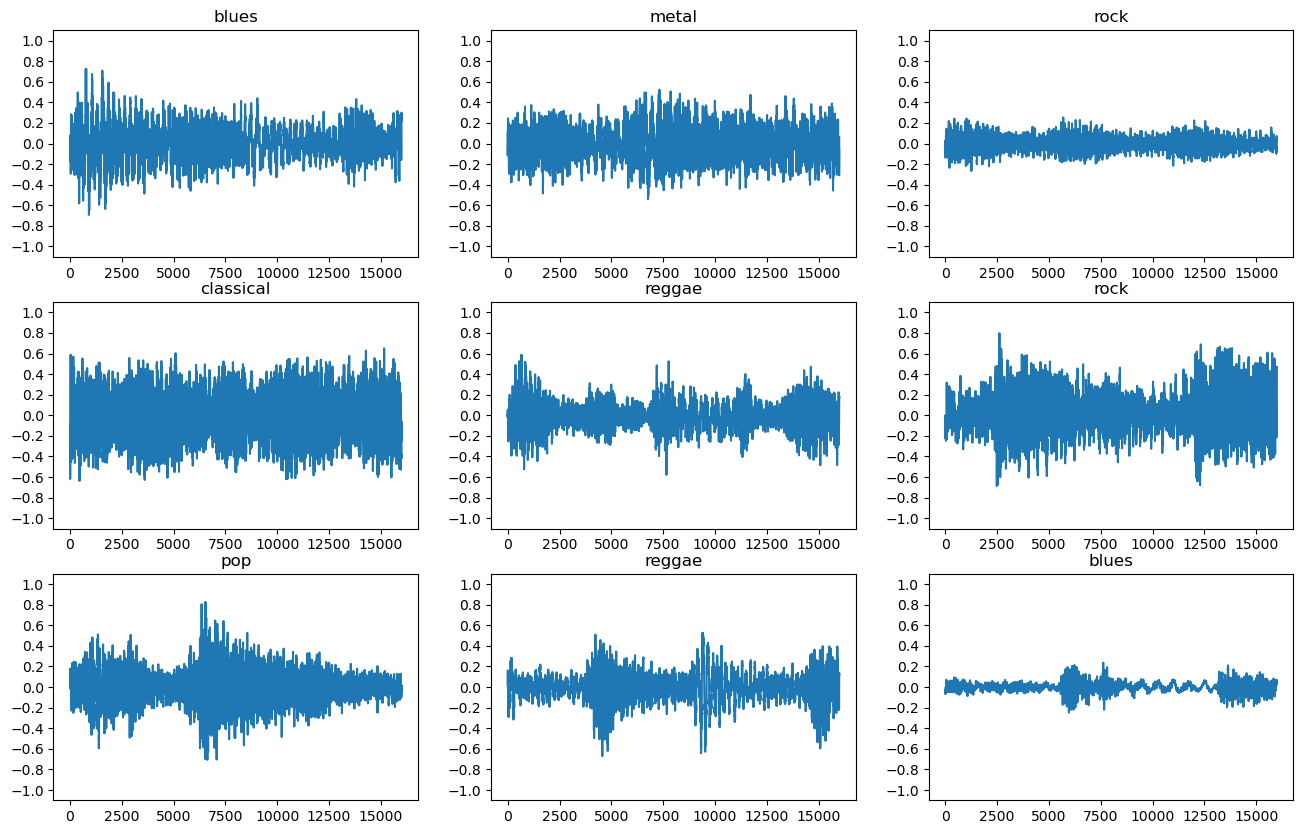

In [10]:
#Let's plot a few audio waveforms
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

# Convert waveforms to spectrograms

In [11]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [12]:
#start exploring the data. Print the shapes of one example's tensorized waveform 
#and the corresponding spectrogram, and play the original audio
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: blues
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: metal
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: rock
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [13]:
#Define a function for displaying a spectrogram:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

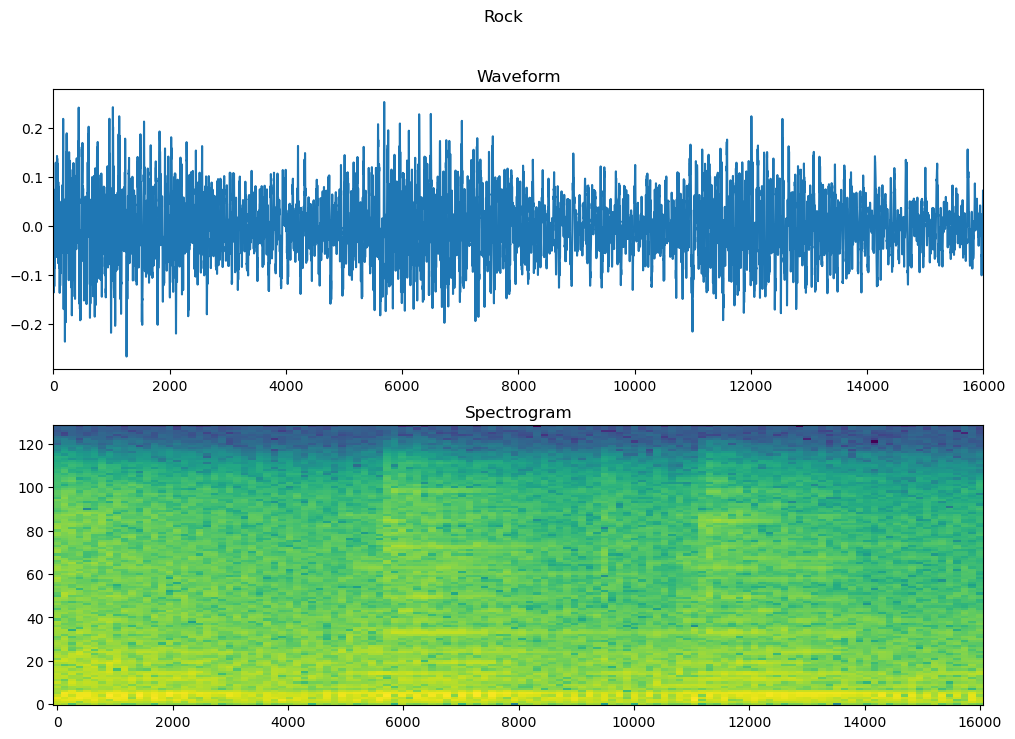

In [14]:
#Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [15]:
#Now, create spectrogram datasets from the audio datasets:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [17]:
#Examine the spectrograms for different examples of the dataset:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break


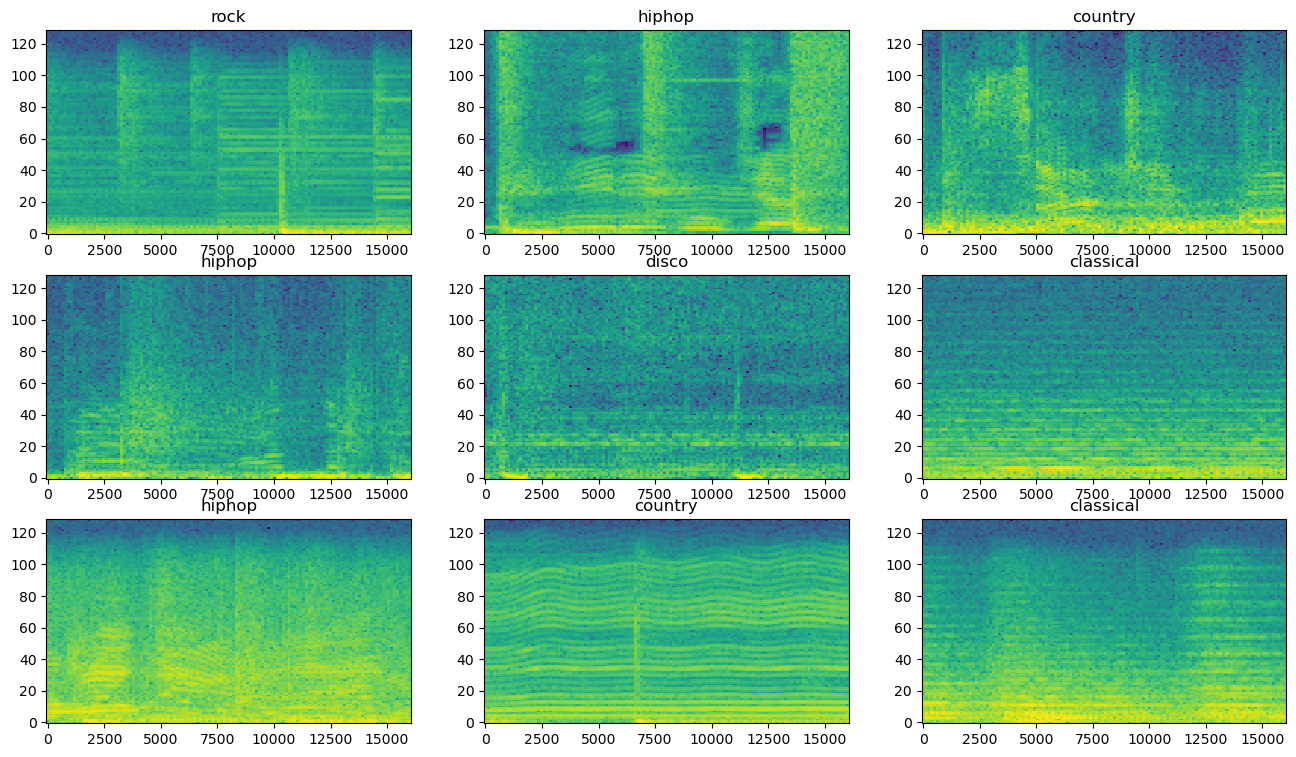

In [18]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

# Build and train the model

In [19]:
#Add Dataset.cache and Dataset.prefetch operations to reduce read latency while training the model:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [20]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)         

In [21]:
#Configure the Keras model with the Adam optimizer and the cross-entropy loss:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


In [24]:
#For demonstration purposes train the model over 10 epochs :
EPOCHS = 100 #Try 10 epochs
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    #callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2), #Leo - Commented this out to prevent early stoppage
)


Epoch 1/100
13/13 [==============================] - 0s 34ms/step - loss: 0.7630 - accuracy: 0.7437 - val_loss: 1.8374 - val_accuracy: 0.4648
Epoch 2/100
13/13 [==============================] - 0s 31ms/step - loss: 0.6830 - accuracy: 0.7862 - val_loss: 1.8676 - val_accuracy: 0.4225
Epoch 3/100
13/13 [==============================] - 0s 33ms/step - loss: 0.6969 - accuracy: 0.7738 - val_loss: 1.8782 - val_accuracy: 0.3944
Epoch 4/100
13/13 [==============================] - 0s 32ms/step - loss: 0.6213 - accuracy: 0.8037 - val_loss: 1.9321 - val_accuracy: 0.4648
Epoch 5/100
13/13 [==============================] - 0s 32ms/step - loss: 0.6426 - accuracy: 0.7987 - val_loss: 1.8972 - val_accuracy: 0.4366
Epoch 6/100
13/13 [==============================] - 0s 31ms/step - loss: 0.5449 - accuracy: 0.8375 - val_loss: 1.9483 - val_accuracy: 0.4507
Epoch 7/100
13/13 [==============================] - 0s 32ms/step - loss: 0.5097 - accuracy: 0.8350 - val_loss: 2.1352 - val_accuracy: 0.4225
Epoch 

13/13 [==============================] - 0s 33ms/step - loss: 0.1247 - accuracy: 0.9663 - val_loss: 3.6060 - val_accuracy: 0.4648
Epoch 59/100
13/13 [==============================] - 0s 33ms/step - loss: 0.0946 - accuracy: 0.9725 - val_loss: 3.6259 - val_accuracy: 0.4507
Epoch 60/100
13/13 [==============================] - 0s 32ms/step - loss: 0.1014 - accuracy: 0.9688 - val_loss: 3.5325 - val_accuracy: 0.4085
Epoch 61/100
13/13 [==============================] - 0s 32ms/step - loss: 0.1090 - accuracy: 0.9750 - val_loss: 3.2171 - val_accuracy: 0.4225
Epoch 62/100
13/13 [==============================] - 0s 33ms/step - loss: 0.1005 - accuracy: 0.9638 - val_loss: 3.4945 - val_accuracy: 0.4507
Epoch 63/100
13/13 [==============================] - 0s 32ms/step - loss: 0.1090 - accuracy: 0.9663 - val_loss: 3.7656 - val_accuracy: 0.4225
Epoch 64/100
13/13 [==============================] - 0s 33ms/step - loss: 0.1054 - accuracy: 0.9675 - val_loss: 3.6708 - val_accuracy: 0.4789
Epoch 65/100

Text(0, 0.5, 'Accuracy - Percent [%]')

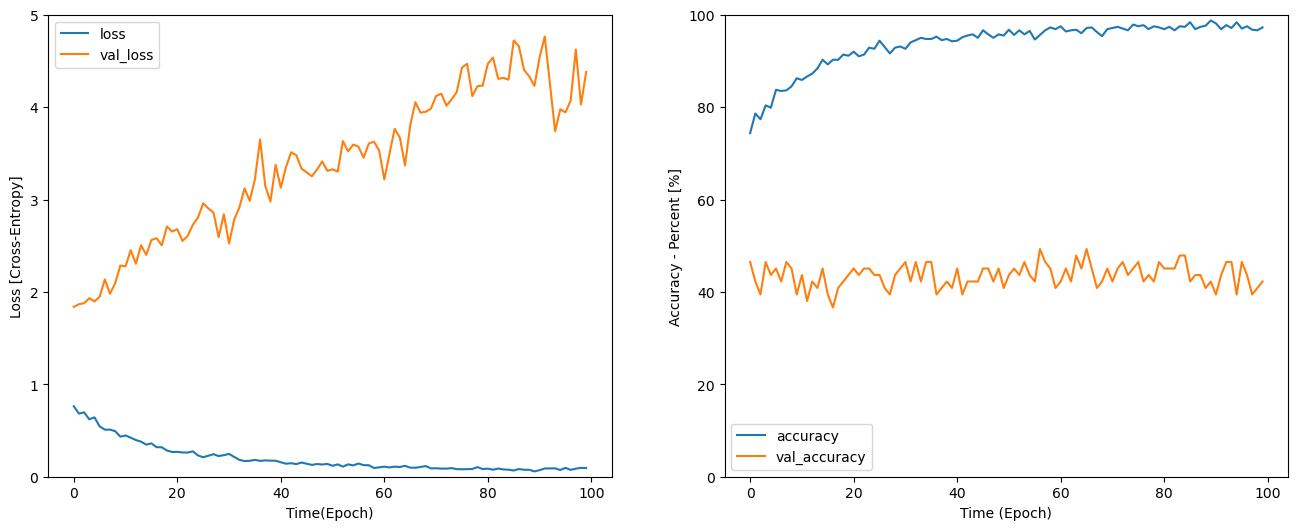

In [26]:
#plot the training and validation loss curves to check how your model has improved during training:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Time(Epoch)')
plt.ylabel('Loss [Cross-Entropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Time (Epoch)')
plt.ylabel('Accuracy - Percent [%]')

# Evaluate the model performance

In [28]:
#Run the model on the test set and check the model's performance:
model.evaluate(test_spectrogram_ds, return_dict=True)

2/2 [==============================] - 0s 15ms/step - loss: 5.9092 - accuracy: 0.3984


{'loss': 5.909214973449707, 'accuracy': 0.3984375}

# Display a confusion matrix

2/2 [==============================] - 0s 18ms/step


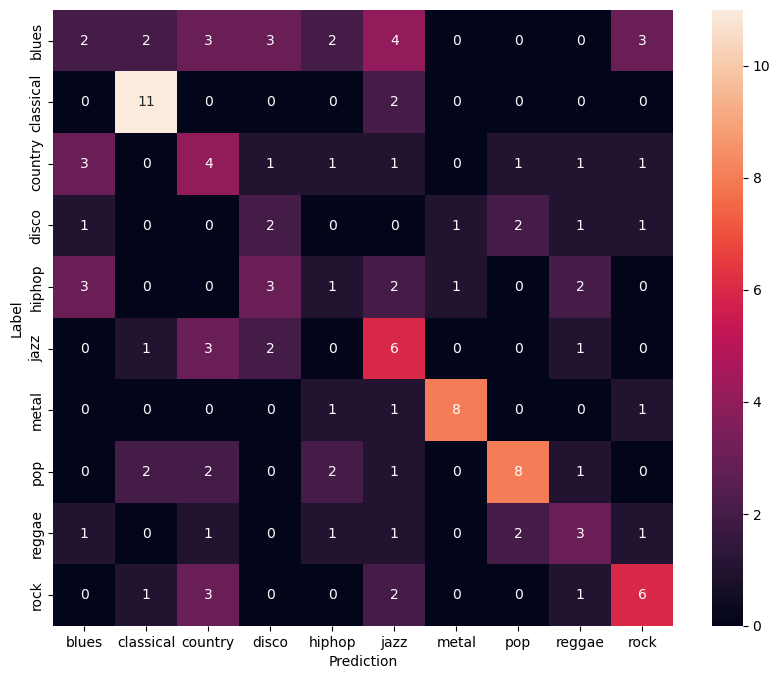

In [29]:
#We use a confusion matrix to check how well the model did classifying each of the commands in the test set:
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

# Run inference on an audio file

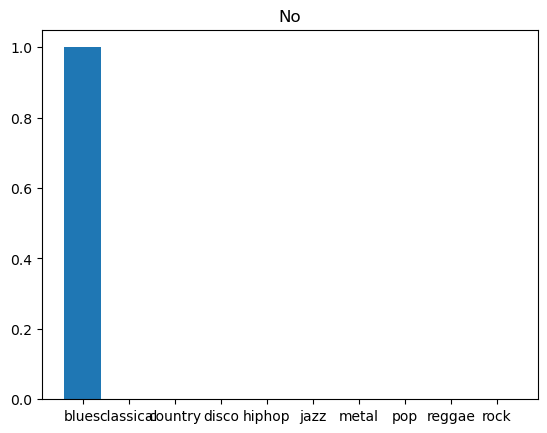

In [30]:
#We verify the model's prediction output using an input audio file
x = data_dir/'blues/blues.00000.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae','rock' ]
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

display.display(display.Audio(waveform, rate=16000))

# Export the model with preprocessing

In [31]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]

    x = get_spectrogram(x)  
    result = self.model(x, training=False)

    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [32]:
#Test run the "export" model:
export = ExportModel(model)

#Save and reload the model, the reloaded model gives identical output:
tf.saved_model.save(export, "saved_jupyter")
imported = tf.saved_model.load("saved_jupyter")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved_jupyter\assets


INFO:tensorflow:Assets written to: saved_jupyter\assets


{'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([0], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'blues'], dtype=object)>,
 'predictions': <tf.Tensor: shape=(1, 10), dtype=float32, numpy=
 array([[ 13.404111  ,  -1.5837882 ,   0.22220695,  -2.297194  ,
          -4.577292  ,  -3.2788386 , -11.48794   ,   0.08765352,
           3.885695  ,  -8.869138  ]], dtype=float32)>}